# Course Demo 3: Optimization for Large Scale Logistic Regression 

Logistic regression is widely used in Machine Learning and Statistics for binary classification.

Given data $(x_1,y_1),\ldots, (x_N,y_N)$, where $x_i\in R^d, y_i\in\{-1,1\}$, $i=1,\ldots,N$, the logistic regresion model assumes that 
$$P(y=1|x,w)=\sigma(w^Tx):=\frac{1}{1+\exp(-w^Tx)}.$$
The maximum likelihood estimation leads to the optimization problem 
$$\min_{w} f(w):=\frac{1}{N}\sum_{i=1}^N \log(1+\exp(-y_iw^Tx_i))+\frac{\lambda}{2}\|w\|_2^2$$
where $\lambda\geq 0$ is the regularization parameter. 

In this demo, we consider the case when $N$ is large and illustrate how to apply some of the algorithms we learnt in class for solving stochastic optimization. In particular, we implement three algorithms,  full Gradient Descent (GD), Stochastic Gradient Descent(SGD), and Stochastic Variance Reduced Gradient(SVRG), and investigate their empirical behaviors. 

In [1]:
%matplotlib inline 
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import normalize
from scipy.special import expit as sigmoid

## Synthetic Data Generation

In [2]:
N = 10000
dim = 50
lamda = 1e-4
np.random.seed(1)
w = np.matrix(np.random.multivariate_normal([0.0]*dim, np.eye(dim))).T
X = np.matrix(np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = N))
X = np.matrix(normalize(X, axis=1, norm='l2'))
y = 2 * (np.random.uniform(size = (N, 1)) < sigmoid(X*w)) - 1

## Real-World Forrest Covertype Dataset

In [ ]:
file = datasets.load_svmlight_file('covtype.libsvm.binary.scale',n_features=54)
y = np.matrix(file[1]).T
X = file[0].todense()
train_idx = np.random.randint(0,X.shape[0], int(0.1*X.shape[0]))
y = y[train_idx,:]
X = np.matrix(normalize(X[train_idx,:], axis=1, norm='l2'))
lamda = 1e-4
N, dim = X.shape
print('dataset of size: {} X {}'.format(N,dim))

In [3]:
import cvxpy as cvx

w = cvx.Variable(dim)
loss = 1/N * cvx.sum_entries(cvx.logistic(-cvx.mul_elemwise(y, X*w))) + lamda/2 * cvx.sum_squares(w)

problem = cvx.Problem(cvx.Minimize(loss))
problem.solve(verbose=True, abstol=1e-15) 
opt = problem.value
print('Optimal Objective function value is: {}'.format(opt))


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.580e+04  +7e+04  6e-01  3e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.452e+00  -3.939e+03  +2e+04  1e-01  1e+00  3e-01  2e-01  0.7833  9e-03   1  1  1 |  1  1
 2  +2.776e+00  -7.226e+02  +4e+03  2e-02  5e-01  1e-01  6e-02  0.7833  7e-02   1  1  1 |  0  1
 3  +2.805e+00  -1.789e+02  +1e+03  3e-03  5e-01  3e-02  2e-02  0.7161  4e-03   1  1  1 |  0  1
 4  +2.790e+00  -3.792e+01  +3e+02  8e-04  3e-01  7e-03  4e-03  0.7833  1e-02   1  1  1 |  1  1
 5  +2.660e+00  -9.423e+00  +8e+01  2e-04  3e-01  2e-03  1e-03  0.7174  3e-02   1  1  1 |  1  1
 6  +2.256e+00  -4.370e-01  +2e+01  5e-05  9e-02  4e-04  3e-04  0.7833  4e-02   1  1  1 |  0  1
 7  +1.425e+00  +9.427e-02  +1e+01  3e-05  4e-02  3e-04  2e-04  0.9791  6e-01   1  1  1 |  0  0
 8  +1.074e+00  +5.875e-01  +4e+00  1e-05  2e-

## Parameters

In [4]:
L = lamda + 1/4;
num_pass = 50

## Full Gradient Descent (GD)


In [5]:
## Define the objective and gradient oracles. 
def obj(w):
    return 1/N * np.sum( np.log(1 + np.exp(-np.multiply(y, (X*w)))) ) + 1/2 * lamda * (w.T*w)

def grad(w,X,y):
    return 1/X.shape[0] * X.T * np.multiply( y, sigmoid(np.multiply(y, X*w)) - 1) + lamda*w

In [6]:
## Gradient Descent
w = np.matrix([0.0]*dim).T
obj_GD = []
max_iter = num_pass
for t in range(0, max_iter):
    obj_val = obj(w)
    w = w - 2/(L+lamda) * grad(w, X, y)
    
    obj_GD.append(obj_val.item())
    
print('Objective function value is: {}'.format(obj_GD[-1]))


Objective function value is: 0.6090202114663853


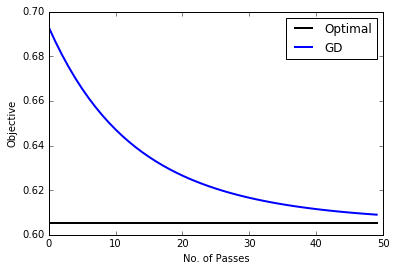

In [7]:
## Plot objective vs. iteration
t = np.arange(0,num_pass)
plt.plot(t, np.ones((len(t),1))*opt, 'k', linewidth = 2, label = 'Optimal')
plt.plot(t, np.array(obj_GD), 'b', linewidth = 2, label = 'GD')
plt.legend(prop={'size':12})
plt.xlabel('No. of Passes')
plt.ylabel('Objective')

## Stochastic Gradient Descent

In [8]:
## Stochastic Gradient Descent
w = np.matrix([0.0]*dim).T
obj_SGD = []
batch = 50
for s in range(num_pass):
    obj_val = obj(w)
    obj_SGD.append(obj_val.item())   
    max_iter = int(N/batch)
    for t in range(max_iter):
        rand_idx = np.random.randint(0, N-1,batch) 
        yt = y[rand_idx, 0]
        xt = X[rand_idx, :]
        # gamma = 1/(lamda*(t+1))             # theoretical stepsize
        gamma = 0.1/(lamda*(t+100))           # better stepsize
        w = w -  gamma * grad(w,xt,yt)

print('Objective function value is: {}'.format(obj_SGD[-1]))       

Objective function value is: 0.6100871334202216


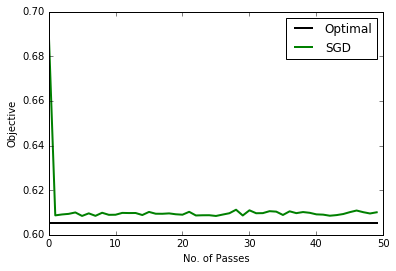

In [9]:
## Plot objective vs. iteration
t = np.arange(0, num_pass)
plt.plot(t, np.ones((len(t),1))*opt, 'k', linewidth = 2, label = 'Optimal')
plt.plot(t, np.array(obj_SGD), 'g', linewidth = 2, label = 'SGD')
plt.legend(prop={'size':12})
plt.xlabel('No. of Passes')
plt.ylabel('Objective')

## Stochastic Variance Reduced Gradient (SVRG)

In [10]:
## SVRG
w = np.matrix([0.0]*dim).T
obj_SVRG = []
passes_SVRG = []

Epochs = 15
k = 2
batch = 50
for s in range(Epochs):
    obj_val = obj(w)
    obj_SVRG.append(obj_val.item())
    passes_SVRG.append(s*k+s)
    
    w_prev = w
    gradient = grad(w, X, y)

    obj_SVRG.append(obj_val.item())
    passes_SVRG.append(s*k+s+1)    
    
    max_iter = int(k*N/batch)
    for t in range(max_iter):
        rand_idx = np.random.randint(0, N-1, batch)
        yt = y[rand_idx, 0]
        xt = X[rand_idx, :]
        gamma = 1/L
        w = w - gamma * (grad(w,xt,yt) - grad(w_prev,xt,yt) + gradient)

print('Objective function value is: {}'.format(obj_SVRG[-1]))       

Objective function value is: 0.6053663828944768


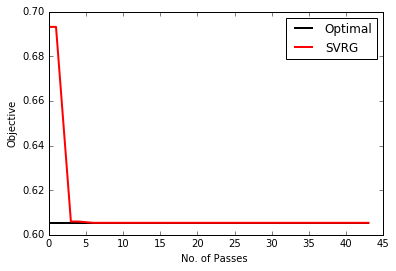

In [11]:
## Plot objective vs. iteration
t = passes_SVRG
plt.plot(t, np.ones((len(t),1))*opt, 'k', linewidth = 2, label = 'Optimal')
plt.plot(t, np.array(obj_SVRG), 'r', linewidth = 2, label = 'SVRG')
plt.legend(prop={'size':12})
plt.xlabel('No. of Passes ')
plt.ylabel('Objective')

## Compare All Algorithms

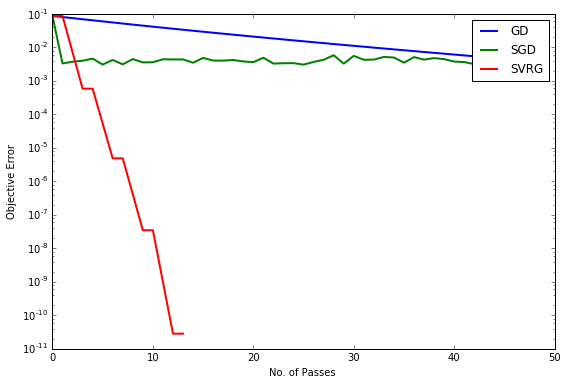

In [12]:
## Compare GD, SGD, SVRG
passes_GD = range(len(obj_GD))
passes_SGD = range(len(obj_SGD))
fig, ax = plt.subplots(figsize = (9, 6))
ax.semilogy(passes_GD, np.array(obj_GD)-opt, color='b', linewidth=2, label='GD')
ax.semilogy(passes_SGD, np.array(obj_SGD)-opt, color='g', linewidth=2, label='SGD')
ax.semilogy(passes_SVRG, np.array(obj_SVRG)-opt, color='r', linewidth=2, label='SVRG')
plt.legend(prop={'size':12})
plt.xlabel('No. of Passes ')
plt.ylabel('Objective Error')